In [1]:
import torch
from fastai.vision.all import *

if torch.cuda.is_available():
    print("CUDA is available on this system.")
else:
    print("CUDA is NOT available on this system.")

/home/ippen/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CUDA is available on this system.


In [2]:
# Fix Display behavior in Jupyter Notebooks for VS Code
from IPython.display import clear_output, DisplayHandle
def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)
DisplayHandle.update = update_patch

(86, 86)


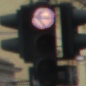

In [3]:
project_path = '/home/ippen/personal/traffic-light-classification/datasets/dtld/cropped_rect_combined/'
image_path = project_path +'train/images'

files = get_image_files(image_path)
img = PILImage.create(files[15])
print(img.shape)
img.to_thumb(128)

In [4]:
from fastcore.parallel import *

def f(o): return PILImage.create(o).size
sizes = parallel(f, files, n_workers=8)
pd.Series(sizes).value_counts()

(79, 79)      334
(80, 80)      324
(82, 82)      322
(78, 78)      317
(81, 81)      312
             ... 
(78, 79)        1
(110, 138)      1
(76, 92)        1
(68, 64)        1
(58, 80)        1
Length: 735, dtype: int64

In [5]:
# Check Maximal Image Size
max_size = 0
for i in range(len(files)):
    img = PILImage.create(files[i])
    if max_size < img.shape[0]:
        max_size = img.shape[0]
    if max_size < img.shape[1]:
        max_size = img.shape[1]
print(max_size)

218


In [6]:
import re

def extract_color(file_path):
    filename = os.path.basename(file_path)
    color_pattern = r"__class_(\w+)-"
    color_match = re.search(color_pattern, filename)
    if color_match:
        return color_match.group(1)
    else:
        raise ValueError(f"Color-Class pattern not found in filename: {filename}")

def extract_pictogram(file_path):
    filename = os.path.basename(file_path)
    pictogram_pattern = r"-(\w+).png$"
    pictogram_match = re.search(pictogram_pattern, filename)
    if pictogram_match:
        return pictogram_match.group(1)
    else:
        raise ValueError(f"Pictogram-Class pattern not found in filename: {filename}")

In [7]:
filename_test = "DE_BBBR667_2015-04-17_10-50-17-633923_k0_86__class_red_yellow-circle.png"
display(extract_color(filename_test))
display(extract_pictogram(filename_test))

'red_yellow'

'circle'

In [8]:
dataset_path = '/home/ippen/personal/traffic-light-classification/datasets/dtld/cropped_rect_combined/'
train_folder = 'train'
valid_folder = 'valid'

dblock = DataBlock(blocks=(ImageBlock, CategoryBlock, CategoryBlock),
                   n_inp=1,
                   get_items=get_image_files,
                   get_y=[extract_color, extract_pictogram],
                   item_tfms=Resize(224, ResizeMethod.Pad, pad_mode='zeros'),
                   batch_tfms=None)

dls = dblock.dataloaders(dataset_path, path=dataset_path, train=train_folder, valid=valid_folder, bs=64)

In [9]:
print("Train size: " + str(len(dls.train.items))+ " | Valid size: " + str(len(dls.valid.items)))

Train size: 17280 | Valid size: 4319


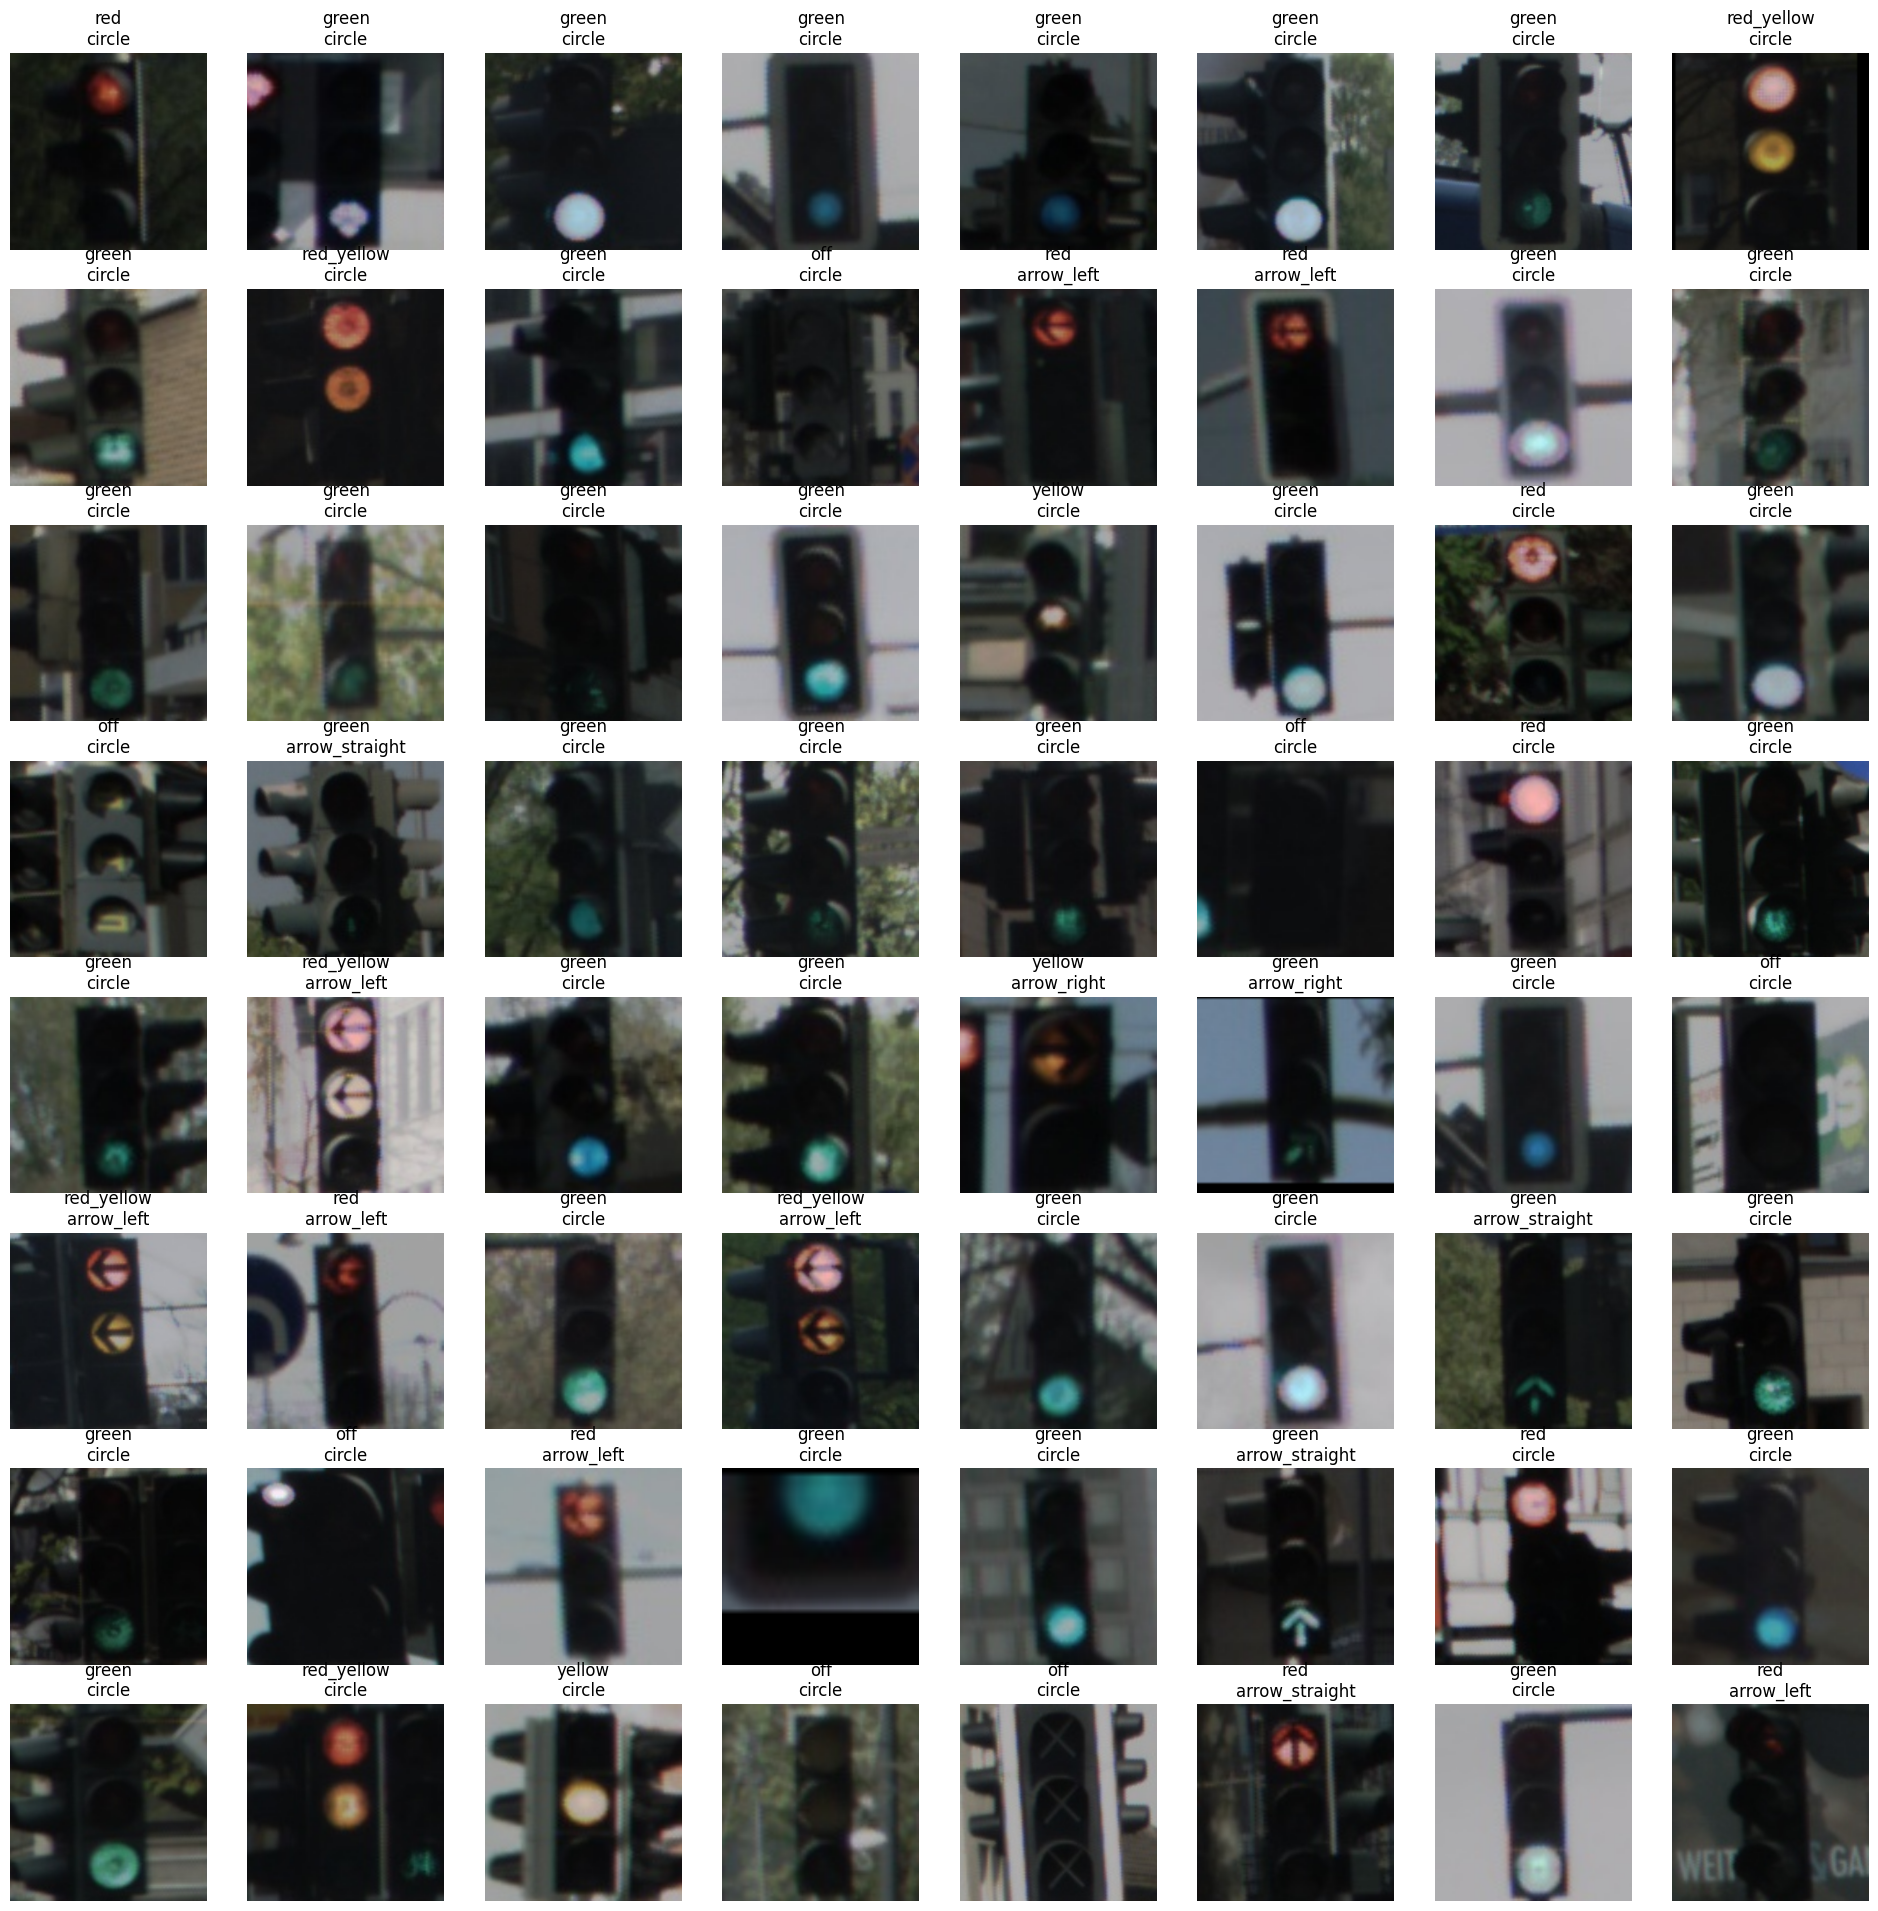

In [17]:
dls.show_batch(max_n=64)

In [10]:
def combine_labels(filename):
    return extract_color(filename) + extract_pictogram(filename)

In [11]:
from tabulate import tabulate

def examine_dataset(split):
    table = []
    headers = ["Split"] + [f"{state}{pictogram}" for state in ["red", "red_yellow", "yellow", "green", "off"] for pictogram in ["circle", "arrow_left", "arrow_straight", "arrow_right"]] + ["Total"]
    
    for sp in split:
        missing_class = [sp]
        labels_file = project_path + sp + '/labels.json'
        
        dataset_path = '/home/ippen/personal/traffic-light-classification/datasets/dtld/cropped_rect_combined/'
        
        files = get_image_files(dataset_path + sp + '/images')
        
        for state in ["red", "red_yellow", "yellow", "green", "off"]:
            for pictogram in ["circle", "arrow_left", "arrow_straight", "arrow_right"]:
                class_label = state + pictogram
                total_items = sum(1 for f in files if combine_labels(f) == class_label)
                missing_class.append(total_items)
        
        num_images = len(files)
        missing_class.append(num_images)
        table.append(missing_class)
    
    display(tabulate(table, headers=headers, tablefmt='html'))

examine_dataset(split = ["train", "valid", "test"])

Split,redcircle,redarrow_left,redarrow_straight,redarrow_right,red_yellowcircle,red_yellowarrow_left,red_yellowarrow_straight,red_yellowarrow_right,yellowcircle,yellowarrow_left,yellowarrow_straight,yellowarrow_right,greencircle,greenarrow_left,greenarrow_straight,greenarrow_right,offcircle,offarrow_left,offarrow_straight,offarrow_right,Total
train,2623,1261,316,82,249,42,21,2,406,91,56,23,6580,509,736,168,1032,17,1,16,14231
valid,1195,476,70,86,113,17,4,6,193,20,1,38,3256,131,234,67,244,6,5,3,6165
test,157,81,22,0,15,2,2,0,56,7,2,0,640,52,35,16,116,0,0,0,1203


### Train and Validation Split
- Train: Berlin, Bochum, Bremen, Duesseldorf, Essen, Fulda, Hannover, Koeln
- Validation: Frankfurt, Dortmund
- Test: Kassel

### Insane speed improvement for new get_y function in DataBlock
Using regex with class labels inside the filename instead of an exhaustive search for labels in JSON greatly improved loading data.

### New square/rectangular image crop
Instead of precisely cropping images, crop a larger square around the traffic light to introduce a background and hopefully better regularize the next models. 